# Classification of Handwritten Digits

The below is an implementation of one of the methods for classifying MNIST data described in [Matrix Methods for Data Mining, Chapter 10](https://epubs.siam.org/doi/abs/10.1137/1.9780898718867.ch10). This is prototype to ensure the logic is sound and works, before proceeding to a more efficient cuda implementation of the same.

In [12]:
%matplotlib inline
import numpy as np
from numpy.linalg import svd, norm
import cv2
from collections import defaultdict
from tqdm import tqdm
from mnist.loader import MNIST
from matplotlib import pyplot as plt
import math

In [13]:
mnist_path = '/home/keshu/Downloads/parallel-svd-ish-stuff-master/data'

In [14]:
mndata = MNIST(mnist_path)

In [15]:
images, labels = mndata.load_training()
n = 28

## Grouping 

The following section groups the images by their labels, for our objective to create SVD bases for each digit.

In [41]:
def group(images, labels, size):
    grouped = defaultdict(list)
    for image, label in zip(images, labels):
        img = np.array(image, dtype=np.float64)
#         img = cv2.resize(img, size,interpolation = cv2.INTER_CUBIC) 
        grouped[label].append(img.ravel())
    return grouped

In [42]:
grouped = group(images, labels, size=(n, n))

In [43]:
len(grouped)

7

## Visualize data

<BarContainer object of 10 artists>

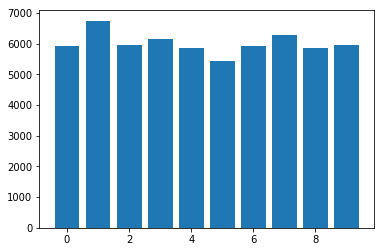

In [18]:
xs, ys = [], []
for key in grouped:
    xs.append(key)
    ys.append(len(grouped[key]))
plt.bar(xs, ys)

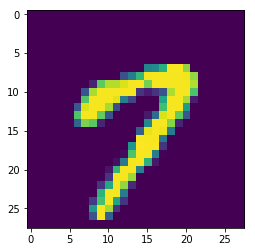

In [19]:
sample = grouped[7][0]
sample = sample.reshape(n, n)
plt.imshow(sample)

## SVD, etc.

The following functions help in creating a basis given a set of images. Applied to images of each digits, we obtain the left singular vectors representative of each digit, which can be considered to form a basis for the digits.

`loss` projects an image into the vectors defined by $U$ and tries to reconstruct it back using the inverse operation. But the process results in loss of information, which we compare with the original sample. Whichever digit's basis leads to least loss of information captures the digit maximum, and can be treated as the label.

### Formulation

The SVD of a matrix $\textbf{A}$ of dimension $d x N$, where $d$ is the size of each input sample, and $N$ the number of input samples is represented by:

$$ A = U\Sigma V^T $$

where U is $d \times d$, $\Sigma$  is a diagonal matrix of dimensions $d \times N$ and $V^T$ of dimensions $N \times N$.

#### Left Singular Vectors

Let $U_k$ be the k best left singular vectors formed by the $U$ matrix. ie,

$$ U_k = U[:, :k]$$

Let the input sample be $z$, then we have:

\begin{align*}
    \alpha &= U_k^Tz \\
    z'&= U_kz    
\end{align*}

#### Classifying digits

If $U_k(i)$ is the U for the ith digit:

\begin{align*}
    z_i' &= U_k(i) z \\
    c &= \arg\min_{i}{\lVert z - z_i' \rVert_2}
\end{align*}

In [20]:
def basis(images):
    A = np.array(images).transpose()
    u, s, vh = svd(A)
    return u
    
def loss(U):
    def _loss(z):
        alpha = np.dot(U.transpose(), z)
        return norm(z - np.dot(U, alpha))
    return _loss

def classify(bases, img):
    losses = []
    for key in bases:
        _loss = (key, loss(bases[key])(img))
        losses.append(_loss)
    label, value = min(losses, key=lambda x: x[1])
    return label

## Experiments

The following describes what to do,using the components constituting our key logic defined above. First we use the training set to create basis for each digit, and use the obtained ones on the testing set. Accuracies of both training and testing are reported below.

In [21]:
def accuracy(stats):
    total = sum(stats.values())
    return stats[True]/total

In [22]:
bases = {}
k = 9

for key in tqdm(grouped, desc='computing bases'):
    bases[key] = basis(grouped[key])[:,:k]


computing bases: 100%|██████████| 10/10 [02:00<00:00, 13.62s/it]


In [23]:
stats = defaultdict(int)
for key in tqdm(grouped, desc='training'):
    for img in grouped[key]:
        label = classify(bases, img)
        stats[label == key] += 1
print(stats, accuracy(stats))            

training: 100%|██████████| 10/10 [01:44<00:00,  9.72s/it]

defaultdict(<class 'int'>, {False: 3509, True: 56491}) 0.9415166666666667


In [24]:
stats = defaultdict(int)
images, labels = mndata.load_testing()
for img, label in tqdm(zip(images, labels), desc='testing', total=len(images)):
    img = np.array(img, dtype=np.float64)
    prediction = classify(bases, img)
    stats[label == prediction] += 1
print(stats, accuracy(stats))

testing: 100%|██████████| 10000/10000 [00:16<00:00, 619.59it/s]

defaultdict(<class 'int'>, {True: 9477, False: 523}) 0.9477


## Analysis

The following section tries to analyze the left singular images for each digit, to see what's happening under the hood.

In [25]:
def tile(images, shape):
    n = len(images)
    rows, cols = shape
    grid, ls = [], []
    s, _= images[0].shape
    def cat(ls):
        ls = np.concatenate(ls, axis=1)
        grid.append(ls)
        
    for i in range(n):
        ls.append(images[i])
        if len(ls)%rows == 0:
            cat(ls)
            ls = []
    while len(ls)%rows != 0:
        white = np.zeros((s, s), dtype=np.float64)
        ls.append(white)
    
    if ls: cat(ls)
    grid = np.concatenate(grid, axis=0)
    return grid

def lsv(basis, size):
    m, n = basis.shape
    s = int(math.sqrt(m))
    images = []
    for i in range(n):
        img  = basis[:, i].reshape(s, s)
        images.append(img)   
    return tile(images, (3, 3))    


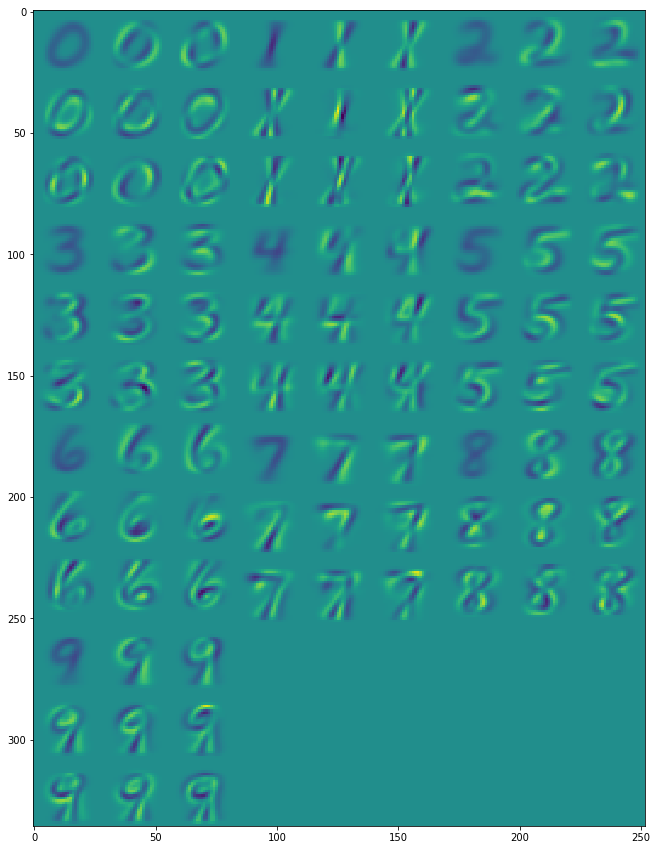

In [28]:
images = []
for key in sorted(bases):
    img = lsv(bases[key], (3, 3))
    images.append(img)

image = tile(images, (3, 3))
plt.figure(figsize=(15,15))
plt.imshow(image)